# Quick Overview

In this task, you will implement a simple variant of [EfficientDet](https://arxiv.org/abs/1911.09070) for the segmentation task on [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/). 
It is a simplified task where the pet can be classified as foreground.

The dataset consists of RGB images of pets accompanied by a segmentation mask. The mask is an array of integers, that has entries equal to:
* 1 - for the pixels of the image that belong to the pet
* 2 - for the background
* 3 - for the ambiguous parts (like pet boundary and accessories) - we will call this an outline of a pet

The task is divided into four parts that contribute to your total score as follows:
* dataset preparation - 0.5p
* data visualization - 0.5p
* architecture implementation - 5p
* evaluation metrics - 1p
* training loop - 1p
* experiments - 2p

The first two subtasks consider dataset preparation (applying appropriate transforms) and data visualization.

In the next one, you are tasked with finishing the implementation of a model that should utilize:
* [EfficientNet](https://arxiv.org/pdf/1905.11946.pdf) backbone
* [BiFPN](https://arxiv.org/abs/1911.09070)-like module 
* Fully convolutional head for predicting whether a pixel belongs to the pet, the background, or the pet outline

Given a batch of input images of shape `(BATCH, 3, IMAGE_HEIGHT, IMAGE_WIDTH)` the model should produce a tensor of shape `(BATCH, 3, PREDICTION_HEIGHT, PREDICTION_WIDTH)` consisting of logits used later for determining whether the point belongs to the pet, the background, or the pet outline.

Next, you will implement IOU and accuracy metrics, and finish the training loop (the evaluation function is already provided).

In the end, you will check how much the model benefits from the use of the feature pyramid and check the effects of the train set augmentation in a low data regime.

# Intro

## Libraries

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

## Dataset Preparation (0.5p)

Read this section and provide input and target transforms. 
Transforms should pass the checks presented at the end of the section.

Input (Image) transforms should consist of:
* resize to ``(IMAGE_HEIGHT, IMAGE_WIDTH)``
* normalization with parameters matching ImageNet (provided below)

Target (Mask) transforms should consist of:
* resize to ``(PREDICTION_HEIGHT, PREDICTION_WIDTH)`` that maintains the domain (i.e. if each element of the mask was from the set {1, 2, 3} then so does each element after the resize)
* subtraction of 1 from each element of the target (to make 0 correspond to the pet, 1 to the background, and 2 to the outline)
* conversion to `torch.long`

Both inputs and targets should be converted to tensors.

Each image should have shape `(3, IMAGE_HEIGHT, IMAGE_WIDTH)`, 
whereas each target `(PREDICTION_HEIGHT, PREDICTION_WIDTH)`.

HINT:
* `torchvision.transforms.ToTensor()`
* `torchvision.transforms.PILToTensor()`
* `torchvision.transforms.Normalize(...)`
* `torchvision.transforms.Resize(..., interpolation=...)`
* `torchvision.transforms.Lambda(...)`

In [2]:
# We downscale images to
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128

# We will make predictions in a smaller scale
PREDICTION_HEIGHT = 64
PREDICTION_WIDTH = 64


# We want to match data distribution
# of the backbone that we will introduce later
image_net_mean = [0.485, 0.456, 0.406]
image_net_std = [0.229, 0.224, 0.225]

input_transforms = torchvision.transforms.Compose(
    [
        ## TODO {
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Resize((IMAGE_HEIGHT, IMAGE_WIDTH)),
        torchvision.transforms.Normalize(image_net_mean, image_net_std)
        ## }
    ]
)

target_transforms = torchvision.transforms.Compose(
    [
        ## TODO {
        torchvision.transforms.PILToTensor(),
        torchvision.transforms.Resize((PREDICTION_HEIGHT, PREDICTION_WIDTH), interpolation = torchvision.transforms.InterpolationMode.NEAREST),
        torchvision.transforms.Lambda(lambda y: (y - 1).long().squeeze())
        #torchvision.transforms.ConvertImageDtype(torch.long) ?
        ## }
    ]
)

In [3]:
# Directory for dataset storage
DATA_PATH = "~/torch_datasets/oxford"

TRAIN_DATASET = torchvision.datasets.OxfordIIITPet(
    root=DATA_PATH,
    split="trainval",
    download=True,
    target_types="segmentation",
    transform=input_transforms,
    target_transform=target_transforms,
)
TEST_DATASET = torchvision.datasets.OxfordIIITPet(
    root=DATA_PATH,
    split="test",
    download=True,
    target_types="segmentation",
    transform=input_transforms,
    target_transform=target_transforms,
)

  0%|          | 0/791918971 [00:00<?, ?it/s]

Extracting /root/torch_datasets/oxford/oxford-iiit-pet/images.tar.gz to /root/torch_datasets/oxford/oxford-iiit-pet


  0%|          | 0/19173078 [00:00<?, ?it/s]

Extracting /root/torch_datasets/oxford/oxford-iiit-pet/annotations.tar.gz to /root/torch_datasets/oxford/oxford-iiit-pet


In [4]:
BATCH_SIZE = 16
TRAIN_LOADER = torch.utils.data.DataLoader(
    TRAIN_DATASET, shuffle=True, batch_size=BATCH_SIZE
)
TEST_LOADER = torch.utils.data.DataLoader(
    TEST_DATASET, shuffle=True, batch_size=BATCH_SIZE
)

Let's ensure that shapes and types match our expectations.

In [5]:
samples = next(iter(TRAIN_LOADER))
images, masks = samples

assert len(images.shape) == 4
assert images.shape[0] == BATCH_SIZE
assert images.shape[1] == 3
assert images.shape[2] == IMAGE_HEIGHT
assert images.shape[3] == IMAGE_WIDTH
assert images.dtype == torch.float32

assert len(masks.shape) == 3
assert masks.shape[0] == BATCH_SIZE
assert masks.shape[1] == PREDICTION_HEIGHT
assert masks.shape[2] == PREDICTION_WIDTH
assert masks.dtype == torch.long
assert (masks <= 2).all()
assert (masks >= 0).all()

## Data Visualization (0.5p)
Finish the implementation of `visualize_data` according to its docstring.

In [6]:
def get_pet_mask(mask):
    """
    Given a mask from Oxford-IIIT Pet Dataset after subtraction of 1
    returns the array that encodes parts belonging to the pet.
    """
    return (mask == 0).type(torch.long)


def get_pet_background(mask):
    """
    Given a mask from Oxford-IIIT Pet Dataset after subtraction of 1
    returns the array that encodes parts belonging to the background.
    """
    return (mask == 1).type(torch.long)


def get_pet_outline(mask):
    """
    Given a mask from Oxford-IIIT Pet Dataset after subtraction of 1
    returns the array that encodes parts belonging to the pet outline.
    """
    return (mask == 2).type(torch.long)

In [7]:
def visualize_data(images, masks):
    """
    Args:
        images: tensor of shape (BATCH, 3, H, W)
        masks: tensor of shape (BATCH, H, W)
    Draws a grid of images of size BATCH x 4.
    I'th row consists of the image, pet mask, pet outline, and background mask.
    """
    assert len(images.shape) == 4
    assert len(masks.shape) == 3
    num_images = images.shape[0]
    assert masks.shape[0] == num_images

    ## TODO {
    f, axarr = plt.subplots(len(images),4)
    for i in range(len(images)):
      pet = get_pet_mask(masks[i])
      bck = get_pet_background(masks[i])
      out = get_pet_outline(masks[i])
      #plt.imshow(np.transpose(images[i], (1, 2, 0)))
      axarr[i,0].imshow(np.transpose(images[i], (1, 2, 0)))
      axarr[i,1].imshow(pet)
      axarr[i,2].imshow(bck)
      axarr[i,3].imshow(out)
    plt.show()
    ## }

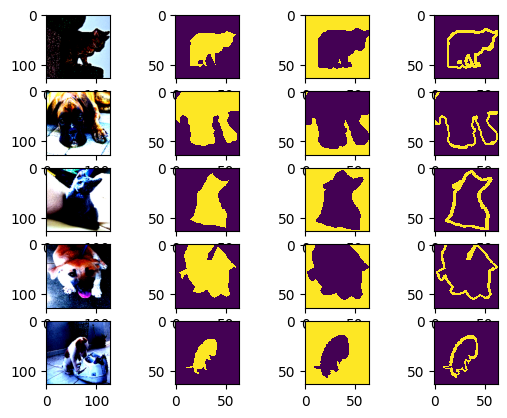

In [8]:
visualize_data(images[:5], masks[:5])

# Model

## Backbone Selection

We are going to use [EfficientNet](https://arxiv.org/abs/1905.11946v5) as the backbone of our model. Below we install a PyTorch implementation and a package for model summarization.

In [9]:
!pip install efficientnet_pytorch
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16444 sha256=999d3f0700955353ba728e575fec1f005af1ec9abb9e32edbe30f53a9f57dedf
  Stored in directory: /root/.cache/pip/wheels/29/16/24/752e89d88d333af39a288421e64d613b5f652918e39ef1f8e3
Successfully built efficientnet_pytorch
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [72]:
from efficientnet_pytorch import EfficientNet
backbone = EfficientNet.from_pretrained('efficientnet-b0').to(device='cuda')

Loaded pretrained weights for efficientnet-b0


In [73]:
import torchinfo
torchinfo.summary(backbone, input_size=(1, 3, IMAGE_HEIGHT, IMAGE_WIDTH), device="cuda")

Layer (type:depth-idx)                             Output Shape              Param #
EfficientNet                                       [1, 1000]                 --
├─Conv2dStaticSamePadding: 1-1                     [1, 32, 64, 64]           864
│    └─ZeroPad2d: 2-1                              [1, 3, 129, 129]          --
├─BatchNorm2d: 1-2                                 [1, 32, 64, 64]           64
├─MemoryEfficientSwish: 1-3                        [1, 32, 64, 64]           --
├─ModuleList: 1-4                                  --                        --
│    └─MBConvBlock: 2-2                            [1, 16, 64, 64]           --
│    │    └─Conv2dStaticSamePadding: 3-1           [1, 32, 64, 64]           288
│    │    └─BatchNorm2d: 3-2                       [1, 32, 64, 64]           64
│    │    └─MemoryEfficientSwish: 3-3              [1, 32, 64, 64]           --
│    │    └─Conv2dStaticSamePadding: 3-4           [1, 8, 1, 1]              264
│    │    └─MemoryEfficientSwish

The backbone has a method that allows easy feature extraction.
Below we inspect this method.

In [74]:
import json

dummy_input = torch.zeros((1, 3, IMAGE_HEIGHT, IMAGE_WIDTH))
dummy_input = dummy_input.to(device = 'cuda')
features = backbone.extract_endpoints(dummy_input)

FEATURE_SHAPES = {
    feature_name: feature_data.shape for feature_name, feature_data in features.items()
}
FEATURE_CHANNELS = dict(
    list(
        {
            feature_name: feature_shape[1]
            for feature_name, feature_shape in FEATURE_SHAPES.items()
        }.items()
    )
)


print(json.dumps(FEATURE_SHAPES, indent=4))
print(json.dumps(FEATURE_CHANNELS, indent=4))

{
    "reduction_1": [
        1,
        16,
        64,
        64
    ],
    "reduction_2": [
        1,
        24,
        32,
        32
    ],
    "reduction_3": [
        1,
        40,
        16,
        16
    ],
    "reduction_4": [
        1,
        112,
        8,
        8
    ],
    "reduction_5": [
        1,
        320,
        4,
        4
    ],
    "reduction_6": [
        1,
        1280,
        4,
        4
    ]
}
{
    "reduction_1": 16,
    "reduction_2": 24,
    "reduction_3": 40,
    "reduction_4": 112,
    "reduction_5": 320,
    "reduction_6": 1280
}


## Architecture Implementation (5p)

### Backbone Utils (0.5p)
Finish the implementation of `BackBoneWrapper` according to docstrings.

In [82]:
class MatchChannels(torch.nn.Module):
    """
    Given the input of shape (BATCH, in_channels, H, W),
    converts it to the one of shape (BATCH, out_channels, H, W)
    """

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = torch.nn.Conv2d(
            in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=1
        ).to(device='cuda')
        self.bn = torch.nn.BatchNorm2d(out_channels).to(device='cuda')

    def forward(self, x):
        assert len(x.shape) == 4
        x = self.conv(x)
        x = self.bn(x)
        return x


class BackBoneWrapper(torch.nn.Module):
    """
    Given the input x of shape (BATCH, 3, IMAGE_HEIGHT, IMAGE_WIDTH)
    produces the list of features, each having out_channels channels.
    Features are taken from the output self.backbone.extract_endpoints(x)
    and converted using MatchChannels to have an appropriate number of channels.
    Features are ordered from the top to the bottom
    (first the ones of high resolution; note that FEATURE_FILTERS maintains this order).
    """

    def __init__(self, out_channels):
        super().__init__()
        self.backbone = EfficientNet.from_pretrained("efficientnet-b0").to(device = 'cuda')

        self.feature_channels = FEATURE_CHANNELS
        self.num_feature_levels = len(self.feature_channels.items())

        ## TODO{
        self.matchchannels = [MatchChannels(self.feature_channels[f"reduction_{i+1}"], out_channels) for i in range(self.num_feature_levels)]
        ## }

    def forward(self, x):
        assert len(x.shape) == 4
        assert x.shape[1] == 3

        feature_level_dict = self.backbone.extract_endpoints(x)

        ## TODO{
        result = [self.matchchannels[i](feature_level_dict[f"reduction_{i+1}"]) for i in range(self.num_feature_levels)]
        ## }

        assert len(result) == self.num_feature_levels
        for i in range(self.num_feature_levels):
            assert (
                result[i].shape[-2:]
                == feature_level_dict[f"reduction_{i+1}"].shape[-2:]
            )
        return result

### Feature Fusion (1.5p)
Finish the implementation of `FeatureFusionBlock` according to docstrings.

In [88]:
class FeatureFusionBlock(torch.nn.Module):
    """
    Used to fuse features from different levels in the feature pyramid.
    Given
        current_feature (of shape (BATCH, feature_channels, H, W))
        previous_feature (of shape (BATCH, feature_channels, H', W'))
        and optionally additional_feature (of shape (B, feature_channels, H, W))
    fuses them using the following equation
        for the case without additional_feature
            ACT(BN(CONVS(p1*current_feature + p2*resize(previous_feature))))
        for the case with additional_feature
            ACT(BN(CONVS(p1*current_feature + p2*resize(previous_feature) + p3*additional_feature)))
        where CONVS are convolution(s) used to process features after addition 
            (choice about the number of them and their properties is up to you)
        BN is the batch norm
        ACT is an activation function (for example it can be relu)
        p1, p2, p3, are scalars calculated using learnable weights (see the EfficientDet paper).

    """

    def __init__(self, feature_channels, use_additional):
        """
        Args:
            feature_channels - number of channels that each feature has
            use_additional - whether additional_feature will be provided
        """
        super().__init__()
        self.use_additional = use_additional
        ## TODO {
        self.act = torch.nn.ReLU().to(DEVICE)
        self.bn = torch.nn.BatchNorm2d(feature_channels).to(DEVICE)
        self.conv = torch.nn.Conv2d(feature_channels, feature_channels, 1).to(DEVICE)
        self.scalar1 = torch.nn.Parameter(torch.ones(1)).to(DEVICE)
        self.scalar2 = torch.nn.Parameter(torch.ones(1)).to(DEVICE)
        self.scalar3 = torch.nn.Parameter(torch.ones(1)).to(DEVICE)
        ## }

    def forward(self, current_feature, previous_feature, additional_feature):
        # Below we check that self.use_additional iff additional_feature is not None
        assert not self.use_additional or additional_feature is not None
        assert self.use_additional or additional_feature is None

        assert len(current_feature.shape) == len(previous_feature.shape)
        assert current_feature.shape[:2] == previous_feature.shape[:2]
        if additional_feature is not None:
            assert current_feature.shape == additional_feature.shape

        ## TODO {
        resize = torchvision.transforms.Resize((current_feature.shape[2], current_feature.shape[3]))
        if self.use_additional:
          combined = self.act(self.bn(self.conv(self.scalar1 * current_feature + self.scalar2 * resize(previous_feature) + self.scalar3 *  additional_feature)))
        else:
          combined = self.act(self.bn(self.conv(self.scalar1 * current_feature + self.scalar2 * resize(previous_feature))))
        ## }

        assert combined.shape == current_feature.shape

        return combined

### BiFPN (1.5p)
Finish the implementation of `BiFPN` according to docstrings.

In [89]:
class BiFPN(torch.nn.Module):
    """
    Implements BiFPN similar to the one presented in EfficinetDet Paper.
    Given num_feature_levels features, each having feature_channels channels
    performs up and down feature fusion process using FeatureFusionBlocks.
    """

    def __init__(self, num_feature_levels, feature_channels):
        super().__init__()
        self.feature_channels = feature_channels
        self.num_feature_levels = num_feature_levels
        
        ## TODO {
        self.ffb = [FeatureFusionBlock(self.feature_channels, False) for i in range(self.num_feature_levels)]
        self.ffbwa = [FeatureFusionBlock(self.feature_channels, True) for i in range(self.num_feature_levels - 2)]
        ## }

    def forward(self, features, skip_down=False):
        """
        Args:
            features - self.num_feature_levels features 
                       ordered from the highest to the lowest resolution.
            skip_down - if true then skip the second part of the feature fusion
                        (from high resolution to low resolution)
        Returns:
            list of fused features ordered in the same way as the input
        """
        assert len(features) == self.num_feature_levels

        ## TODO {
        if skip_down:
          outs = [features[-1]]
          out = features[-1]
          for i, j in zip(range(len(features)-1), range(len(features)-2, -1, -1)):
            outs.append(self.ffb[i](features[j], out, None))
            out = self.ffb[i](features[j], out, None)
          
          result = []
          for i in range(len(features)-1, -1, -1):
            result.append(outs[i])
        else:  

          outs = []
          out = features[-1]
          for i, j in zip(range(len(features)-1), range(len(features)-2, -1, -1)):
            outs.append(self.ffb[i](features[j], out, None))
            out = self.ffb[i](features[j], out, None)
          
          result = [outs[-1]]
          out1 = outs[-1]
          for i, j in zip(range(len(features)-2), range(len(features)-3, -1, -1)):
            result.append(self.ffbwa[i](outs[j], out1, features[i+1]))
            out1 = self.ffbwa[i](outs[j], out1, features[i+1])

          result.append(self.ffb[-1](features[-1], out1, None))
        ## }

        assert len(result) == self.num_feature_levels
        assert result[0].shape == features[0].shape

        return result

### Segmentation Head (0.5p)
Finish the implementation of `SegmentationHead` according to docstrings. 
Segmentation head outputs logits that can be used to classify pixels as either pet, background, or outline.

In [107]:
class SegmentationHead(torch.nn.Module):
    """
    Given an input of shape (B, feature_channels, H, W)
    Produces the output of shape (B, num_classes, H', W') (where H', W' = output_shape)
    consisting of logits that can be used to classify each pixel.
    To do so uses additional convolution(s) that operate on input with inner_channels channels.
    """

    def __init__(
        self,
        feature_channels,
        output_shape=(PREDICTION_HEIGHT, PREDICTION_WIDTH),
        inner_channels=64,
        num_classes=3,
    ):
        super().__init__()
        self.output_shape = output_shape
        self.num_classes = num_classes
        ## TODO {
        self.inner = inner_channels
        self.feature_channels = feature_channels
        self.conv1 = torch.nn.Conv2d(self.feature_channels, self.inner, 3, 1, 1)
        self.conv2 = torch.nn.Conv2d(self.inner, self.num_classes, 3, 1, 1)
        self.act = torch.nn.ReLU()
        ## }

    def forward(self, x):
        ## TODO {
        result = self.conv1(x)
        result = self.conv2(result)
        result = self.act(result)
        #print(result.shape[2:], x.shape[2:])
        ## }

        assert result.shape[0] == x.shape[0]
        assert result.shape[1] == self.num_classes
        assert result.shape[2:] == self.output_shape
        return result

### Network (1p)
Combine modules implemented above into a model for semantic segmentation according to docstrings. 

Number of BiFPN modules is up to you.


In [108]:
from itertools import chain

class Net(torch.nn.Module):
    """
    Uses BackBoneWrapper with feature_channels as a backbone.
    Uses BiFPN.
    Returns a tensor of shape (BATCH, 3, H, W) (where H, W = output_shape)
    with logits for pet, background, and outline. 
    """

    def __init__(
        self, feature_channels=128, output_shape=(PREDICTION_HEIGHT, PREDICTION_WIDTH)
    ):
        super().__init__()
        ## TODO {
        self.feature_channels = feature_channels
        self.bbw = BackBoneWrapper(self.feature_channels)
        self.bifpn = BiFPN(6, self.feature_channels)
        #self.bifpn1 = BiFPN(6, self.feature_channels)
        #self.bifpn2 = BiFPN(6, self.feature_channels)
        self.sh = SegmentationHead(self.feature_channels)
        ## }

    def non_backbone_parameters(self):
        """
        Returns all parameters except the backbone ones
        """
        ## TODO {
        parameters = chain(self.bifpn.parameters(), self.sh.parameters())
        ## }
        return parameters

    def forward(self, x):
        ## TODO {
        segmentation = self.bbw(x)
        segmentation = self.bifpn(segmentation)
        segmentation = self.bifpn(segmentation)
        segmentation = self.bifpn(segmentation, True)
        segmentation = self.sh(segmentation[0])
        ## }
        assert segmentation.shape[0] == x.shape[0]
        assert segmentation.shape[1] == 3 # logits for pet, background and outline
        return segmentation

# Metrics and training

## IOU and accuracy (1p)

Implement IOU and accuracy metrics according to docstrings. Use `numpy` for implementation. Note that B and C below are treated as batch dimensions and in our case C=3. 

In both metrics, `prediction` and `ground_truth` are arrays that consist of zeros and ones.

In [60]:
def iou_metric(prediction, ground_truth):
    """
    Given prediction of shape (B, C, H, W)
    and ground_truth of shape (B, C, H, W)
    outputs an array of shape (B, C).
    such that at the position (b, c) is the
    value of the intersection of the prediction and the ground_truth mask 
    (i.e. number of points where both are 1)
    divided by their union (i.e. number of points where at least one is 1) 
    (assume 0/0 = 0).
    """

    assert len(prediction.shape) == 4
    assert prediction.shape == ground_truth.shape
    assert np.logical_or(prediction == 1, prediction == 0).all()
    assert np.logical_or(ground_truth == 1, ground_truth == 0).all()
    ## TODO {
    result = np.zeros((len(prediction), len(prediction[0])))
    for b in range(len(prediction)):
      for c in range(len(prediction[0])):
        if np.sum(prediction[b][c] == 1) +  np.sum(ground_truth[b][c] == 1) - np.sum((prediction[b][c] == ground_truth[b][c])  & (prediction[b][c] == 1)) == 0 and np.sum((prediction[b][c] == ground_truth[b][c]) & (prediction[b][c] == 1)) == 0:
          result[b,c] = 0
        else:
          result[b,c] = np.sum((prediction[b][c] == ground_truth[b][c]) & (prediction[b][c] == 1))/(np.sum(prediction[b][c] == 1) +  np.sum(ground_truth[b][c] == 1) - np.sum((prediction[b][c] == ground_truth[b][c])  & (prediction[b][c] == 1)))

    ## }
    assert result.shape == prediction.shape[:2]
    return result

In [20]:
# Some tests

a = np.zeros((1, 1, 64, 64))
a[:, :, 32:48, 32:48] = 1
b = np.zeros((1, 1, 64, 64))
b[:, :, 47:63, 47:63] = 1

assert np.isclose(
    iou_metric(np.concatenate([a, a], axis=1), np.concatenate([a, b], axis=1)),
    np.array([1.0, 1.0 / 511.0])[None, :],
).all()

c = np.zeros((1, 1, 64, 64))

assert np.isclose(
    iou_metric(c, c),
    np.array([0.0])[:, None],
).all()

In [61]:
def accuracy(prediction, ground_truth):
    """
    Given prediction of shape (B, C, H, W)
    and ground_truth of shape (B, C, H, W)
    outputs an array of shape (B, C).
    such that at the position (b, c) is the
    fraction of all pixels correctly classified
    """

    assert len(prediction.shape) == 4
    assert prediction.shape == ground_truth.shape
    assert np.logical_or(prediction == 1, prediction == 0).all()
    assert np.logical_or(ground_truth == 1, ground_truth == 0).all()
    ## TODO {
    result = np.zeros((len(prediction), len(prediction[0])))
    for b in range(len(prediction)):
      for c in range(len(prediction[0])):
        result[b][c] = np.sum(prediction[b][c] == ground_truth[b][c])/(len(prediction[b][c])*len(prediction[b][c][0]))
    ## }
    assert result.shape == prediction.shape[:2]
    return result

In [22]:
assert np.isclose(
    accuracy(np.concatenate([a, a], axis=1), np.concatenate([a, b], axis=1)),
    np.array([1.0, (4096-510)/4096])[None, :],
).all()

## Evaluation
The code for evaluation is provided below.

Note that as the model returns logits, we take the most probable answer (among pet, background and outline).

In [62]:
## TODO {
DEVICE = 'cuda' #cuda
## }

In [94]:
def one_hot_encode_prediction(predictions):
    """
    Given predictions of shape (B, H, W)
    with number
    0 - representing pixels belonging to the pet,
    1 - background,
    2 - outline
    one hot encodes it as
    single tensor of shape (B, 3, H, W), such that
    element (b, c, h, w) is 1 if the pixel corresponds
    to class c and 0 otherwise.
    """

    assert len(predictions.shape) == 3

    predictions_oh = torch.nn.functional.one_hot(predictions, num_classes=3)
    predictions_oh = predictions_oh.permute(0, 3, 1, 2)  # B, C, H, W

    assert len(predictions_oh.shape) == 4
    assert predictions_oh.shape[1] == 3

    return predictions_oh


def eval_fn(model, test_loader):
    model.eval()

    iou = []
    acc = []
    total = 0
    for data in test_loader:
        x, y = data
        ground_truth = one_hot_encode_prediction(y).cpu().numpy()
        x, y = x.to(DEVICE), y.to(DEVICE)

        logits = model(x)
        prediction = torch.argmax(logits.detach(), dim=-3, keepdim=False)
        prediction = one_hot_encode_prediction(prediction).cpu().numpy()

        iou.append(np.sum(iou_metric(prediction, ground_truth), axis=0))
        acc.append(np.sum(accuracy(prediction, ground_truth), axis=0))
        total += prediction.shape[0]

    iou = np.stack(iou, axis=-1).sum(-1) / total
    acc = np.stack(acc, axis=-1).sum(-1) / total
    assert len(iou.shape) == 1
    assert len(acc.shape) == 1
    assert iou.shape[0] == 3
    assert acc.shape[0] == 3

    print(f"IOU PET: {iou[0]}")
    print(f"IOU BG: {iou[1]}")
    print(f"IOU OUT: {iou[2]}")

    print(f"ACC PET: {acc[0]}")
    print(f"ACC BG: {acc[1]}")
    print(f"ACC OUT: {acc[2]}")

## Training (1p)

Complete the training loop.
You can use `CrossEntropyLoss` as a loss.   

In [95]:
def train(
    model,
    optimizer,
    train_loader,
    test_loader,
    num_epoch,
    eval_fn,
    weight=torch.tensor([1.0, 1.0, 1.0], device=DEVICE),
    augment_fn=(lambda im, gt: (im, gt)),
):
    """
    Args:
        model - model that given an image outputs a tensor
                with logits for determining whether a pixel belongs
                to the pet, the background, or the pet outline.
        eval_fn - function that given a model performs its evaluation on a given set;
                  called at the end of every epoch to report both test and train performance
        weight - used as weights for CrossEntropyLoss
        augment_fn - optional function that given batched input image, and batched target performs random augmentations,
                      used only for train set augmentation

    """
    ## TODO {
    weight = weight.to(DEVICE)
    criterion = torch.nn.CrossEntropyLoss(weight)
    for epoch in range(num_epoch):
          running_loss = 0.0
          for i, data in enumerate(train_loader, 0):
              # get the inputs; data is a list of [inputs, labels]
              #data.to(DEVICE)
              inputs, labels = data
              inputs = inputs.to(DEVICE)
              labels = labels.to(DEVICE)
              # zero the parameter gradients
              optimizer.zero_grad()

              # forward + backward + optimize
              model = model.to(DEVICE)
              outputs = model(inputs)
              #print(outputs.size(), labels.size())
              loss = criterion(outputs, labels)
              loss.backward()
              optimizer.step()

              # print statistics
              running_loss += loss.item()
              if i % 200 == 199:    # print every 200 mini-batches
                  print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                  running_loss = 0.0
          
          eval_fn(model, test_loader)
    ## }

Train the model. You should be able to achieve 80% pet IOU, 87% background IOU and 45% outline IOU on the test set after a few epochs (pet IOU >= 75%, background IOU >= 80%, and outline IOU >= 40% are also ok).  
Remember to provide appropriate parameters to the optimizer (we do not want to train the backbone) and to turn off gradients for backbone parameters.

In [109]:
import torch.optim as optim

def create_model_and_optimizer():
    ## TODO {
    model = Net()
    optimizer = optim.Adam(model.non_backbone_parameters(), lr=0.001)
    ## }
    return model, optimizer


model, optimizer = create_model_and_optimizer()
train(model, optimizer, TRAIN_LOADER, TEST_LOADER, 3, eval_fn)

Loaded pretrained weights for efficientnet-b0
[1,   200] loss: 0.072
IOU PET: 0.4796732647588837
IOU BG: 0.6698908882223462
IOU OUT: 0.08822489365438412
ACC PET: 0.7680284776165167
ACC BG: 0.7800709518303693
ACC OUT: 0.8804933304161556
[2,   200] loss: 0.066
IOU PET: 0.4998072136514447
IOU BG: 0.6698216330603977
IOU OUT: 0.18630020364601482
ACC PET: 0.7835917271395476
ACC BG: 0.7828242379139412
ACC OUT: 0.8851097774427636
[3,   200] loss: 0.065
IOU PET: 0.49657997416831434
IOU BG: 0.6797199144253714
IOU OUT: 0.26790269529078486
ACC PET: 0.7960924058624625
ACC BG: 0.7894935555924639
ACC OUT: 0.8786149980197261


In [ ]:
def save_checkpoint(model, dir):
    torch.save(model.state_dict(), dir)

def load_checkpoint(model, dir):
    model.load_state_dict(torch.load(dir))

In [ ]:
save_checkpoint(model, "pet_segmentator.model")

Let's inspect what model is producing.

In [ ]:
samples = next(iter(TEST_LOADER))
images, _ = samples

images = images[:4]
logits = model(images.to(DEVICE))
prediction = torch.argmax(logits.detach(), dim=-3, keepdim=False)


visualize_data(images.cpu(), prediction.cpu())

# Experiments and ablations (2p)

## No BiFPN (1p)
Disable BiFPN and train the model. Compare the performance with the previous one. 
That is, make BiFPN an identity on features.   
Do it without redefining the class `Net`.

In [ ]:
## TODO {

## }
train(model, optimizer, TRAIN_LOADER, TEST_LOADER, 3, eval_fn)

## Train Set Augmentations (1p)

To quickly see how data augmentation can help in learning we will restrict ourselves to first 20 images of `TRAIN_DATASET`.

In [ ]:
images, masks = [], []
it = iter(TRAIN_DATASET)
for i in range(20):
    img, mask = next(it)
    images.append(img)
    masks.append(mask)

stacked_images = torch.stack(images).repeat((200, 1, 1, 1))
stacked_masks = torch.stack(masks).repeat((200, 1, 1))


SMALL_TRAIN_DATASET = torch.utils.data.TensorDataset(stacked_images, stacked_masks)

SMALL_TRAIN_LOADER = torch.utils.data.DataLoader(
    SMALL_TRAIN_DATASET, shuffle=True, batch_size=BATCH_SIZE
)

Complete the implementation of the augmentation function and train the model from scratch on the augmented dataset (use the `SMALL_TRAIN_LOADER` presented above). Write a short summary of the results. Augmentations are up to you, but they should result in performance improvement.

In [ ]:
def augment_data(images, ground_truth):
    """
    Args:
        images of shape (B, 3, H, W)
        ground_truth of shape (B, H', W')
    Returns augmented images and ground_truth.
    Augmentation is random.
    """

    batch_size = images.shape[0]
    assert len(images.shape) == 4 # (B, 3, H, W)
    assert len(ground_truth.shape) == 3 # (B, H', W')

    assert ground_truth.shape[0] == batch_size

    ## TODO {

     ## }

    assert aug_images.shape == images.shape
    assert ground_truth.shape == aug_gt.shape
    assert torch.logical_or(aug_gt == 0, torch.logical_or(aug_gt == 1, aug_gt == 2)).all()


    return aug_images, aug_gt

In [ ]:
samples = next(iter(SMALL_TRAIN_LOADER))
images, masks = samples

images = images[:4]
masks = masks[:4]


visualize_data(images, masks)

In [ ]:
aug_imgs, aug_masks = augment_data(images, masks)


visualize_data(aug_imgs, aug_masks)

In [ ]:
model, optimizer = create_model_and_optimizer()
train(model, optimizer, SMALL_TRAIN_LOADER, TEST_LOADER, 3, eval_fn)

In [ ]:
model, optimizer = create_model_and_optimizer()
train(model, optimizer, SMALL_TRAIN_LOADER, TEST_LOADER, 3, eval_fn, augment_fn=augment_data)

YOUR REPORT HERE

# Optional
Below you are provided with code for testing you model on images from the web. It may not work in colab!

In [ ]:
load_checkpoint(model, "pet_segmentator.model")

In [ ]:
import io
import requests
from PIL import Image


def download_image(url):
    req = requests.get(url, timeout=4.0)
    if req.status_code != requests.codes.ok:
        raise ConnectionError("Could not request image")

    return Image.open(io.BytesIO(req.content))


img_list = [
    download_image(
        "https://upload.wikimedia.org/wikipedia/commons/thumb/9/95/Young_tabby_cat_keeping_watch.jpg/1920px-Young_tabby_cat_keeping_watch.jpg?20190125193716"  #By W.carter - Own work, CC0, https://commons.wikimedia.org/w/index.php?curid=76097663
    ),
    download_image( 
        "https://upload.wikimedia.org/wikipedia/commons/thumb/a/a0/Cat_blooper.jpg/1920px-Cat_blooper.jpg?20190116232839" # By W.carter - Own work, CC0, https://commons.wikimedia.org/w/index.php?curid=75900016
    ),
]
img = []
for i in img_list:
    img.append(input_transforms(i))


img = torch.stack(img, dim=0)
logits = model(img.to(DEVICE))

prediction = torch.argmax(logits.detach(), dim=-3, keepdim=False)

masks = prediction.detach().cpu()



visualize_data(img, masks)